# Script to prompt LLMs

In [2]:
# import packages
import requests
import json
import pandas as pd
import os
import openai
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

from visualization import *
from utils import *

In [3]:
# If OpenAI used
# Get API key from the environment variable
api_key = os.environ.get('OPENAI_API_KEY')

# Set the API key
openai.api_key = api_key

In [4]:
# Define function to create a prompt
def create_prompt(object_name, N_responses):
    #prompt = f"Generate alternative uses for the object [{object_name}]."
    prompt = f"""
        You are meant to assist students in group ideation. They are asked to propose alternative
        uses for an object and you should propose yours to give them ideas as well as inspire them to 
        explore other uses. 
        You are a very creative, open-minded person and can propose creative, out-of-the-box ideas while staying realistic. 
        Your ideas will be even more appreciated if they are original or useful in real-life or both.
        
        Generate alternative uses for the object [{object_name}]. 
        
        Provide {N_responses} alternative uses, each explained in a concise sentence and following these examples: 
        Sock, Color it and maybe make a snake
        Sock, Use it as a puppet
        Sock, Use it as a dusting cloth
        """
        
    return prompt


# Define function to call the LLM API
def call_openai_api(prompt):
    client = OpenAI()
    response = client.chat.completions.create(
        model = "gpt-3.5-turbo-0125",
        #model="gpt-4-0125-preview", 
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
            ]#,
        #seed=seed,
        #max_tokens=200,
        #temperature=temperature,
        )
    return response


# Define function to store the result in a JSON file
def store_result_json(object_name, alternative_uses):
    result = [{"object_name": object_name, "alternative_uses": use} for use in  alternative_uses.split("\n") if use.strip()]
    with open(f"./data_ocsai/input_ocsai/aut_{object_name}.json", "w") as json_file:
        json.dump(result, json_file)


# Define function to create a CSV file and Pandas DataFrame
def create_csv_and_dataframe(object_name):
    with open(f"./data_ocsai/input_ocsai/aut_{object_name}.json", "r") as json_file:
        data = json.load(json_file)
    df = pd.DataFrame(data)
    
    # remove prefix
    df['alternative_uses']= df['alternative_uses'].apply(lambda x: x.split(", ", 1)[1])
    #df['alternative_uses'] = df['alternative_uses'].str.split(f': ').str[1]
    #df['alternative_uses'] = df['alternative_uses'].str.split(f'{object_name}: ').str[1]
    
    #rename the columns to fit ocsai format
    df = df.rename(columns={"object_name": "prompt", "alternative_uses": "response"})
    
    # save for evaluation
    #df.to_csv(f"./data_ocsai/input_ocsai/aut_{object_name}.csv", index=False)
    
    # Delete the JSON file
    os.remove(f"./data_ocsai/input_ocsai/aut_{object_name}.json")
    
    return df

# Define function to estimate the price of an OpenAI API request
def estimate_price(prompt_tokens, response_tokens):
    # Define your pricing model (e.g., price per token)
    price_per_input_token = 0.50 / 1e6 # gpt3.5-turbo-0125
    price_per_output_token = 1.5 / 1e6 # gpt3.5-turbo-0125
    #price_per_input_token = 10 / 1e6 # gpt4-0125-preview
    #price_per_output_token = 30 / 1e6 # gpt4-0125-preview
    
    # Estimate the price based on the total number of tokens
    price = (prompt_tokens * price_per_input_token) + (response_tokens * price_per_output_token)
    return price

# plot mean from outputs LLMs in the histogram of ground truth
def plot_mean_histogram(ocsai_eval, ground_truth, object_name, ax):
    plt.figure(figsize=(10, 6))
    
    object_ground_truth = ground_truth[ground_truth['prompt'] == object_name]
    
    sns.histplot(object_ground_truth['target'], kde=True, label='Humans', ax = ax)
    ax.vlines(ocsai_eval['originality'].mean(), 0, ax.get_ylim()[1], colors='red', linestyles='dashed', label='LLM')
    ax.set_title(f'Creativity on AUT for {object_name}')
    ax.legend()
    #plt.xlabel('Mean')
    #plt.ylabel('Frequency')

### Main function

In [5]:
ground_truth = pd.read_csv('./../data/cleaned_all_data.csv')

objects = list(ground_truth['prompt'].value_counts().head(4).index)
print(f"Top {len(objects)} of objects in the dataset: {objects}")

Top 4 of objects in the dataset: ['brick', 'box', 'knife', 'rope']


In [6]:
def pipeline_object(object_name, N_responses):
    prompt = create_prompt(object_name, N_responses)
    response = call_openai_api(prompt)
    
    response_content = response.choices[0].message.content
    system_fingerprint = response.system_fingerprint
    prompt_tokens = response.usage.prompt_tokens
    completion_tokens = response.usage.total_tokens - response.usage.prompt_tokens

    print(f"System fingerprint: {system_fingerprint}")
    print(f"Prompt tokens: {prompt_tokens}")
    print(f"Completion tokens: {completion_tokens}")

    price = estimate_price(prompt_tokens, completion_tokens)
    print(f"Estimated price: ${price}")
    
    # store
    store_result_json(object_name, response_content)
    df = create_csv_and_dataframe(object_name)
    return df

def call_api_ocsai(prompt, output_llm):
    base_url = 'https://openscoring.du.edu/llm'
    model = 'ocsai-chatgpt'
    input_value = f"{prompt}, {output_llm}"
    input_type = 'csv'
    elab_method = 'whitespace'
    language = 'English'
    task = 'uses'
    question_in_input = 'false'
    
    # Encode special characters in the input value
    input_value_encoded = input_value.replace(' ', '%20').replace(',', '%2C')
    
    # Construct the URL
    url = f"{base_url}?model={model}&prompt={prompt}&input={input_value_encoded}&input_type={input_type}&elab_method={elab_method}&language={language}&task={task}&question_in_input={question_in_input}"
    
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Error: {response.status_code}")
        return None
    
    return response.json()

## Call to GPT

In [ ]:
# Run the pipeline for each object
object = objects[0]

df = pipeline_object(object, 10)
print(f"length of df: {len(df)}")
df.head()

## Evaluation by ocsai

In [ ]:
for i in tqdm(range(len(df))):
    df.loc[i, 'originality_ocsai'] = call_api_ocsai(df.loc[i, 'prompt'], df.loc[i, 'response'])['scores'][0]['originality']  # see if we can speed up eval if we pass batches of sentences
    df.loc[i, 'elaboration_ocsai'] = call_api_ocsai(df.loc[i, 'prompt'], df.loc[i, 'response'])['scores'][0]['elaboration']

df.head()

In [ ]:
# check if there are any NaNs
if df.isnull().values.any():
    print("There are NaNs in the DataFrame")
else:
    df.to_csv(f'./data_ocsai/aut_{object}.csv', index=False) 
    print("Saved successfully")

In [7]:
# Evaluate (after loading manually the csv on ocsai)
brick_ocsai_eval = pd.read_csv('./data_ocsai/mistral/aut_brick_30.csv')
box_ocsai_eval = pd.read_csv('./data_ocsai/mistral/aut_box_30.csv')
knife_ocsai_eval = pd.read_csv('./data_ocsai/mistral/aut_knife_30.csv')
rope_ocsai_eval = pd.read_csv('./data_ocsai/mistral/aut_rope_30.csv')

# merge the datasets for all objects
ocsai_eval_merged = pd.concat([brick_ocsai_eval, box_ocsai_eval, knife_ocsai_eval, rope_ocsai_eval])
print(f"Length of the merged dataset: {len(ocsai_eval_merged)}")
print(f"Object: {ocsai_eval_merged['prompt'].unique()}")
ocsai_eval_merged.head()

Length of the merged dataset: 120
Object: ['brick' 'box' 'knife' 'rope']


,prompt,response
0,brick,Use it as a doorstop
1,brick,Use it as a paperweight
2,brick,Use it as a paperweight for important documents
3,brick,Use it as a paperweight for your desk
4,brick,Use it as a paperweight for your study table


In [8]:
# save dataset: change name
#ocsai_eval_merged.to_csv('./data_ocsai/mistral/ocsai_eval_merged_30_mistral.csv', index=False) 

In [10]:
# load data 30 samples
ocsai_eval_merged_gpt35_30 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_gpt_35_30.csv')
ocsai_eval_merged_gpt4_30 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_gpt_4_30.csv')
ocsai_eval_merged_mistral_30 = pd.read_csv('./data_ocsai/mistral/ocsai_eval_merged_mistral_30.csv')

# load data 100 & 4x25 samples
ocsai_eval_merged_gpt35_100, ocsai_eval_merged_gpt35_4x25 = load_data_exp1('gpt_35')
ocsai_eval_merged_gpt4_100, ocsai_eval_merged_gpt4_4x25 = load_data_exp1('gpt_4')

display(ocsai_eval_merged_gpt35_100.head(2), ocsai_eval_merged_gpt35_4x25.head(2), ocsai_eval_merged_gpt4_100.head(2), ocsai_eval_merged_gpt4_4x25.head(2), ocsai_eval_merged_mistral_30.head(2))

,prompt,response,originality,elaboration
0,box,Use it as a makeshift stool for reaching high ...,1.7,10.0
1,box,Transform it into a mini-garden by adding soil...,3.0,10.0


,prompt,response,originality,elaboration
0,box,Use it as a mini herb garden by planting herbs...,3.0,11.0
1,box,Convert it into a unique wall shelf by adding ...,2.0,12.0


,prompt,response,originality,elaboration
0,box,Transform it into a mini garden for succulents.,3.0,8.0
1,box,Use it as a makeshift sled on snowy days.,2.0,9.0


,prompt,response,originality,elaboration
0,box,Transform it into a mini greenhouse for starti...,3.0,9.0
1,box,Cut out shapes and use it as a stencil for art...,3.0,12.0


,prompt,response,originality,elaboration
0,brick,Use it as a doorstop,1.0,5
1,brick,Use it as a paperweight,1.0,5


### Evaluate similarity of responses

- rouge score: need to find pairs of sentences
- semantic distance
- use embeddings 

In [ ]:
# compute the rouge score between the outputs of the LLMs

def evaluate_rouge(sentences):
    
    #create pairs of sentences
    pairs = 
    

    rouge = evaluate.load('rouge')
    
    rouge_scores = rouge.compute(predictions=predictions, references=references)

    return rouge_scores


In [ ]:
hofelich_elaboration = pd.read_csv("./../data/hofelich/HMSL_Elaboration_scores_all.csv")

hofelich_elaboration.head()

## Evaluate elaboration

In [11]:
import nltk
from nltk.corpus import stopwords

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to calculate elaboration
def calculate_elaboration(sentence, remove_stop_words):
    # Tokenize the sentence
    tokens = nltk.word_tokenize(sentence)
    
    if remove_stop_words == True:
        # Remove stop words
        tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Count the remaining words
    return len(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# elaboration humans
# apply normal and custom elaboration to ground truth
ground_truth_elab = ground_truth.copy()
ground_truth_elab['elaboration'] = ground_truth_elab['response'].apply(calculate_elaboration, remove_stop_words = False)
ground_truth_elab['elaboration_2'] = ground_truth_elab['response'].apply(calculate_elaboration, remove_stop_words = True)

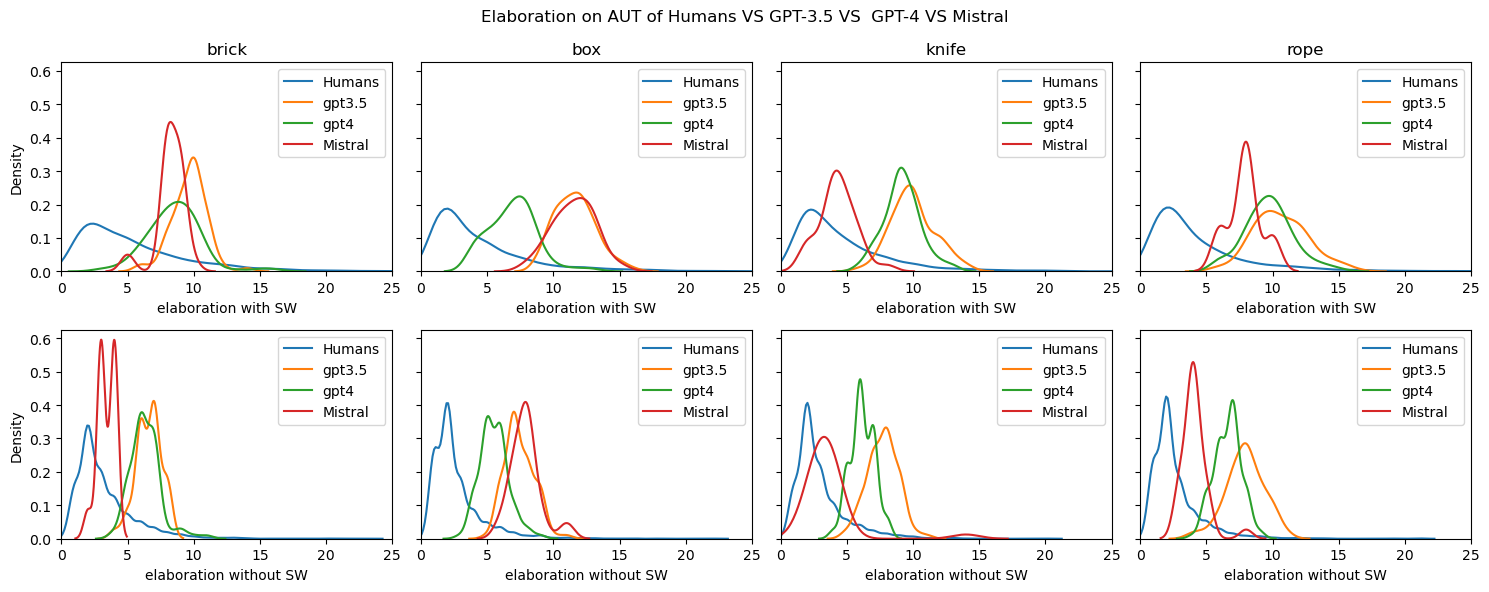

In [30]:
# elaboration humans
# apply normal and custom elaboration to ground truth
ground_truth_elab = ground_truth.copy()
ground_truth_elab['elaboration'] = ground_truth_elab['response'].apply(calculate_elaboration, remove_stop_words = False)
ground_truth_elab['elaboration_2'] = ground_truth_elab['response'].apply(calculate_elaboration, remove_stop_words = True)

# Apply the calculate_elaboration function to the "response" column
ocsai_eval_merged_gpt35_100['elaboration_2'] = ocsai_eval_merged_gpt35_100['response'].apply(calculate_elaboration, remove_stop_words = True)
ocsai_eval_merged_gpt4_100['elaboration_2'] = ocsai_eval_merged_gpt4_100['response'].apply(calculate_elaboration, remove_stop_words = True)
ocsai_eval_merged_mistral_30['elaboration_2'] = ocsai_eval_merged_mistral_30['response'].apply(calculate_elaboration, remove_stop_words = True)

fig, axs = plt.subplots(2,4, figsize=(15, 6), sharey=True)
for i, object_name in enumerate(objects):
    object_ground_truth_elab = ground_truth_elab[ground_truth_elab['prompt'] == object_name]
    object_ocsai_eval_merged_gpt35_100 = ocsai_eval_merged_gpt35_100[ocsai_eval_merged_gpt35_100['prompt'] == object_name]
    object_ocsai_eval_merged_gpt4_100 = ocsai_eval_merged_gpt4_100[ocsai_eval_merged_gpt4_100['prompt'] == object_name]
    object_eval_mgered_mistral_30 = ocsai_eval_merged_mistral_30[ocsai_eval_merged_mistral_30['prompt'] == object_name]
    
    # without stop words removal
    sns.kdeplot(object_ground_truth_elab['elaboration'], label=f'Humans', ax = axs[0, i])
    sns.kdeplot(object_ocsai_eval_merged_gpt35_100['elaboration'], label=f'gpt3.5', ax = axs[0, i])
    sns.kdeplot(object_ocsai_eval_merged_gpt4_100['elaboration'], label=f'gpt4', ax = axs[0,i])
    sns.kdeplot(object_eval_mgered_mistral_30['elaboration'], label=f'Mistral', ax = axs[0,i])
    axs[0,i].set_xlabel('elaboration with SW')
    axs[0,i].set_xlim([0,25])

    # with stop words removal
    sns.kdeplot(object_ground_truth_elab['elaboration_2'], label=f'Humans', ax = axs[1, i])
    sns.kdeplot(object_ocsai_eval_merged_gpt35_100['elaboration_2'], label=f'gpt3.5', ax = axs[1,i])
    sns.kdeplot(object_ocsai_eval_merged_gpt4_100['elaboration_2'], label=f'gpt4', ax = axs[1,i])
    sns.kdeplot(object_eval_mgered_mistral_30['elaboration_2'], label=f'Mistral', ax = axs[1,i])
    axs[1,i].set_xlabel('elaboration without SW')
    axs[1,i].set_xlim([0,25])
    
    axs[0,i].set_title(f'{object_name}')
    axs[0,i].legend()
    axs[1,i].legend()
plt.suptitle(f'Elaboration on AUT of Humans VS GPT-3.5 VS  GPT-4 VS Mistral')
plt.tight_layout()
plt.show()

Optional: compute the correlation between originality and elaboration

directly with the numbers, see if it is significant --> will be hard to analyze

In [51]:
# todo: compute correlation and plot the mean with CI
ocsai_eval_merged_gpt35_100.head()

,prompt,response,originality,elaboration,elaboration_2
0,box,Use it as a makeshift stool for reaching high ...,1.7,10.0,7
1,box,Transform it into a mini-garden by adding soil...,3.0,10.0,6
2,box,Cut it up to create a DIY puzzle for kids.,2.7,10.0,6
3,box,Use it as a base for a homemade pinhole camera.,3.0,10.0,6
4,box,Turn it into a birdhouse by adding a small ent...,2.0,13.0,8


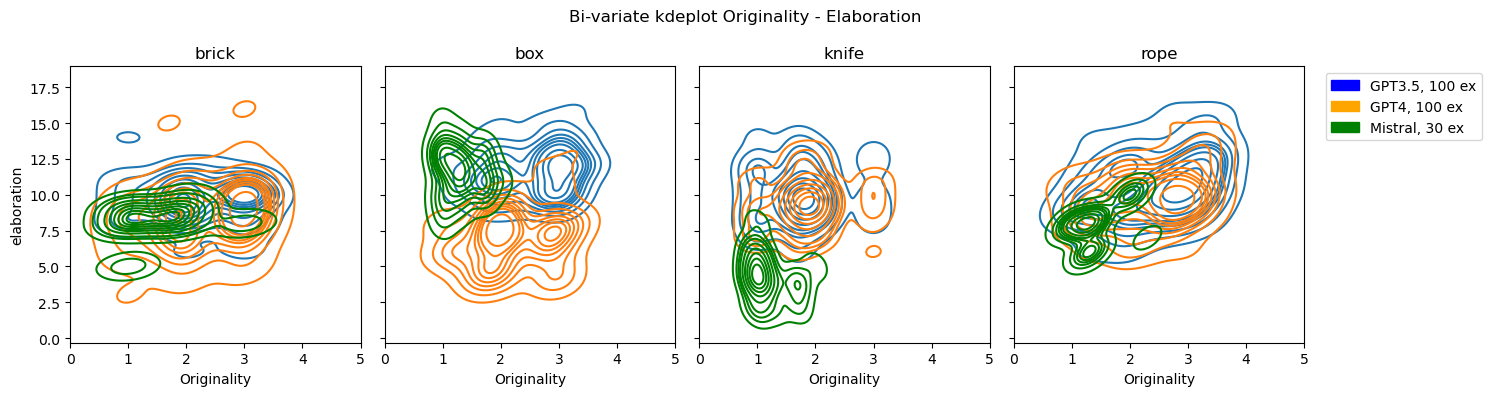

In [39]:
import matplotlib.patches as mpatches

# relation between originality and elaboration
fig, axs = plt.subplots(1,4, figsize=(15, 4), sharey=True)

    # Define custom legend handles
legend_handles = [
    #mpatches.Patch(color='black', label='Humans, N = 100'),
    mpatches.Patch(color='blue', label='GPT3.5, 100 ex'),
    mpatches.Patch(color='orange', label='GPT4, 100 ex'),
    mpatches.Patch(color='green', label='Mistral, 30 ex')
]

for i, object_name in enumerate(objects):
    
    # normalize the values in ground truth and ocsai_eval_merged
    #object_ground_truth = ground_truth_elab[ground_truth_elab['prompt'] == object_name]
    object_ocsai_eval_gpt35_100 = ocsai_eval_merged_gpt35_100[ocsai_eval_merged_gpt35_100['prompt'] == object_name]
    object_ocsai_eval_gpt4_100 = ocsai_eval_merged_gpt4_100[ocsai_eval_merged_gpt4_100['prompt'] == object_name]
    object_ocsai_eval_mistral_30 = ocsai_eval_merged_mistral_30[ocsai_eval_merged_mistral_30['prompt'] == object_name]
    
    #sns.kdeplot(x = object_ground_truth['target'], y = object_ground_truth['elaboration'], label=f'Humans, N = {len(object_ground_truth)}', ax = axs[i])
    sns.kdeplot(x = object_ocsai_eval_gpt35_100['originality'], y = object_ocsai_eval_gpt35_100['elaboration'], label='GPT3.5, 100 ex', ax = axs[i])
    sns.kdeplot(x = object_ocsai_eval_gpt4_100['originality'], y = object_ocsai_eval_gpt4_100['elaboration'], label='GPT4, 100 ex', ax = axs[i])
    sns.kdeplot(x = object_ocsai_eval_mistral_30['originality'], y = object_ocsai_eval_mistral_30['elaboration'], label='Mistral, 30 ex', ax = axs[i],color = 'green')
    
    axs[i].set_title(f'{object_name}')
    axs[i].set_xlabel('Originality')
    axs[i].set_xlim([0,5])
    
#plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1.0))
# Add custom legend with specified handles
plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.05, 1.0))
plt.suptitle(f'Bi-variate kdeplot Originality - Elaboration')
plt.tight_layout()
plt.show()

## Qualitative comparison with embeddings

Compute the cosine similarity of the outputs, by removing the stop words

In [87]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
import seaborn as sns
import matplotlib.pyplot as plt

# Function to encode text into embeddings using a pre-trained language model
def encode_text(texts, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Tokenize input texts and generate embeddings
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**encoded_input)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling to get sentence embeddings
    return embeddings

# Function to compute cosine distance matrix
def compute_cosine_distance_matrix(embeddings):
    cosine_dist_matrix = cosine_distances(embeddings.numpy())
    return cosine_dist_matrix

# Function to visualize cosine distance matrix as heatmap
def visualize_cosine_distance(cosine_dist_matrix, labels, max_length=20):
    # Truncate long sentences
    truncated_labels = [label[:max_length] + '...' if len(label) > max_length else label for label in labels]

    plt.figure(figsize=(15, 15))
    sns.heatmap(cosine_dist_matrix, annot=True, cmap='coolwarm', xticklabels=truncated_labels, yticklabels=truncated_labels)
    plt.title('Cosine Distance Matrix')
    plt.xlabel('Answers')
    plt.ylabel('Answers')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [88]:
text = ocsai_eval_merged_gpt35_100['response'].tolist()[:15]
print(text)

['Use it as a makeshift stool for reaching high places.', 'Transform it into a mini-garden by adding soil and plants.', 'Cut it up to create a DIY puzzle for kids.', 'Use it as a base for a homemade pinhole camera.', 'Turn it into a birdhouse by adding a small entrance hole and perches.', 'Utilize it as a temporary pet carrier in emergencies.', 'Cover it with fabric and use it as a stylish storage ottoman.', 'Place it upside down for a makeshift side table.', 'Use it as a mold for creating custom-shaped soap bars.', 'Cut it into strips and use them as bookmarks.', 'Convert it into a planter for herbs or small vegetables.', 'Use it as a bin to collect recyclables for easy sorting.', 'Disassemble it and repurpose the cardboard for arts and crafts projects.', 'Turn it into a festive gift wrapping station with compartments for ribbons and tags.', 'Cut it into sections to make a DIY advent calendar.']


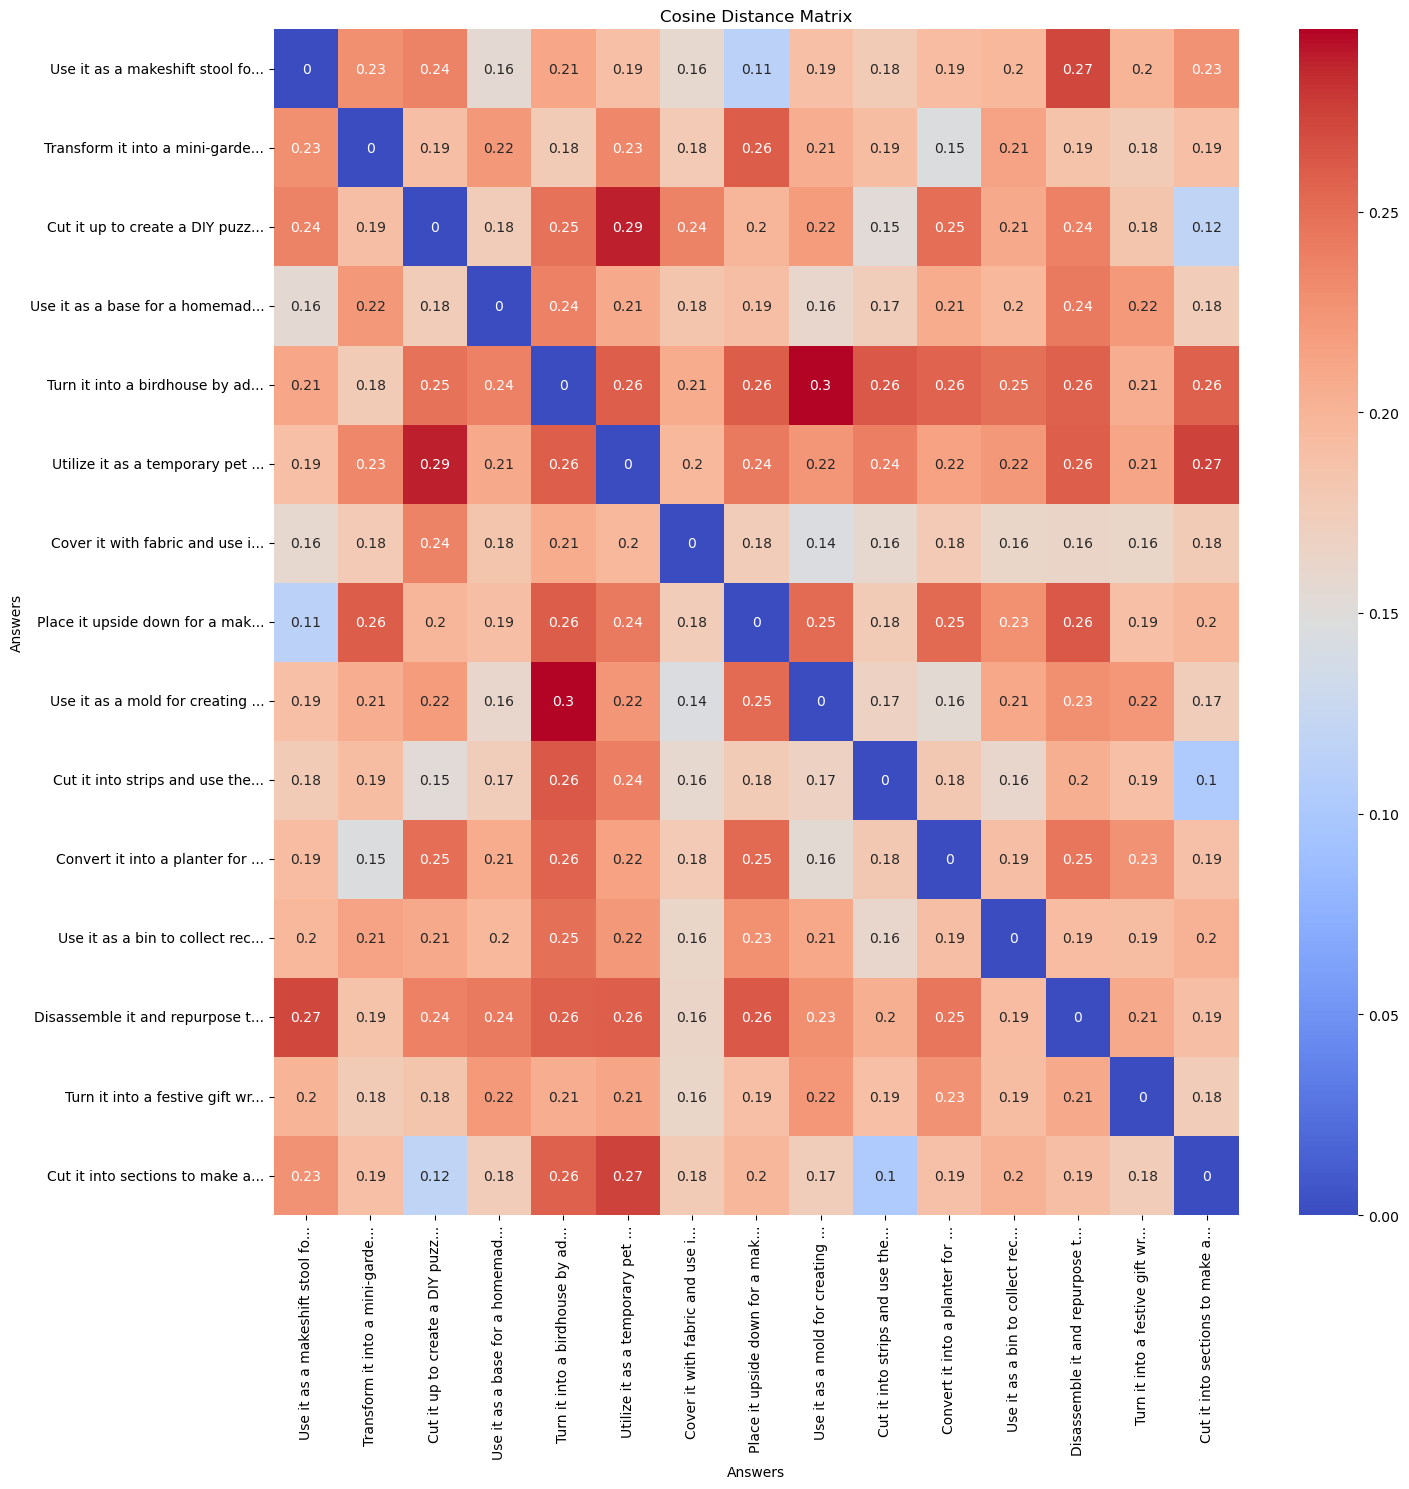

In [89]:

# Example list of textual answers
answers = [
    "The sky is blue.",
    "The sky is cloudy.",
    "The sun is shining brightly.",
    "It's raining outside.",
    "I love to watch the sunset.",
]

# Example pre-trained language model (LLM)
model_name = "distilbert-base-uncased"

# Encode the textual answers into embeddings
#embeddings = encode_text(answers, model_name)
embeddings = encode_text(text, model_name)

# Compute cosine distance matrix
cosine_dist_matrix = compute_cosine_distance_matrix(embeddings)

# Visualize the cosine distance matrix
visualize_cosine_distance(cosine_dist_matrix, text, 30)


In [93]:
# Function to compute average cosine similarity for each sentence
def compute_avg_cosine_similarity(cosine_dist_matrix):
    num_sentences = cosine_dist_matrix.shape[0]
    avg_cosine_similarities = np.zeros(num_sentences)

    for i in range(num_sentences):
        avg_cosine_similarities[i] = np.mean(np.delete(cosine_dist_matrix[i], i))  # Exclude self-similarity

    return avg_cosine_similarities

# Function to plot histogram of cosine similarity scores
def plot_cosine_similarity_histogram(avg_cosine_similarities):
    plt.figure(figsize=(8, 6))
    sns.histplot(avg_cosine_similarities, bins=20, kde=True)
    plt.title('Histogram of Cosine Similarity Scores')
    plt.xlabel('Cosine Similarity Score')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

## for more sentences

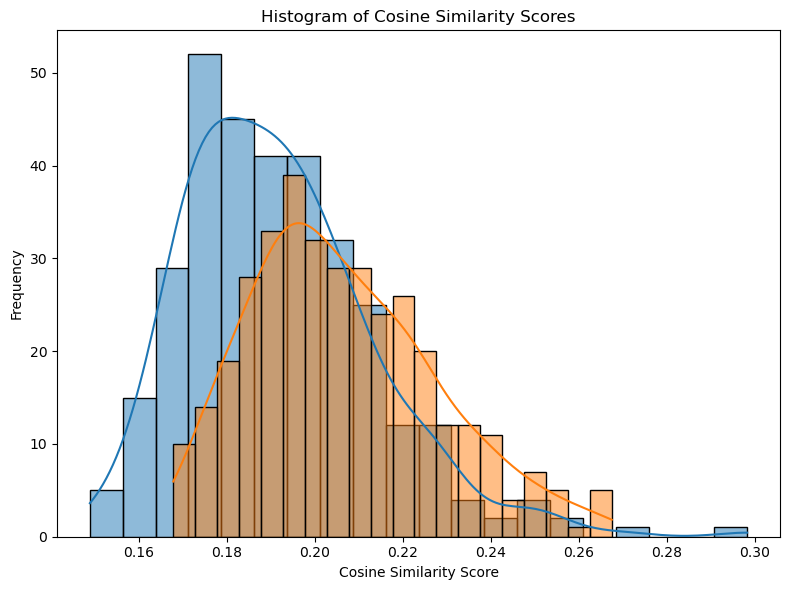

In [95]:
# compare between the two LLMs and ground truth

text = ocsai_eval_merged_gpt35_100['response'].tolist()

def compute_avg_cosine_similarity_df(df, model_name):
    embeddings = encode_text(df['response'].tolist(), model_name)
    cosine_dist_matrix = compute_cosine_distance_matrix(embeddings)
    avg_cosine_similarities = compute_avg_cosine_similarity(cosine_dist_matrix)
    return avg_cosine_similarities

# Compute cosine distance matrix
#cosine_dist_matrix = compute_cosine_distance_matrix(embeddings)

# Visualize the cosine distance matrix
#visualize_cosine_distance(cosine_dist_matrix, text, 30)

# Compute average cosine similarity for each sentence
avg_cosine_similarities_gpt35 = compute_avg_cosine_similarity_df(ocsai_eval_merged_gpt35_100, "distilbert-base-uncased")
avg_cosine_similarities_gpt4 = compute_avg_cosine_similarity_df(ocsai_eval_merged_gpt4_100, "distilbert-base-uncased")
#print("Average Cosine Similarity Scores:", avg_cosine_similarities)

# Plot histogram of cosine similarity scores
#plot_cosine_similarity_histogram(avg_cosine_similarities)
plt.figure(figsize=(8, 6))
sns.histplot(avg_cosine_similarities_gpt35, bins=20, kde=True)
sns.histplot(avg_cosine_similarities_gpt4, bins=20, kde=True)
plt.title('Histogram of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()